<a href="https://colab.research.google.com/github/Willtp6/GAI_project4/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch, torch.nn as nn
from skimage.transform import resize
from skimage.data import chelsea, astronaut
%matplotlib inline


In [5]:
torch.manual_seed(0)
plt.rcParams['font.size'] = '10'; plt.rcParams['toolbar'] = 'None'
plt.ion()

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu"); print(device)

cuda:0


In [7]:
def add_gaussian_noise(image, mean=0, std=0.1):
    # 确保 image 是浮点类型
    image = image.astype(np.float32)
    # 生成高斯噪声
    gauss = np.random.normal(mean, std, image.shape)
    noisy_image = image + gauss
    # 将图像裁剪到 0~1 范围内
    noisy_image = np.clip(noisy_image, 0, 1)
    return noisy_image


In [8]:
def add_poisson_noise(image):
    vals = len(np.unique(image))
    vals = 2 ** np.ceil(np.log2(vals))
    noisy_image = np.random.poisson(image * vals) / float(vals)
    # 确保输出仍然在0到1范围内
    return np.clip(noisy_image, 0, 1)

In [9]:
def add_salt_and_pepper_noise(image, salt_prob=0.05, pepper_prob=0.05):
    row, col, ch = image.shape
    noisy_image = image.copy()

    # 添加盐噪声
    num_salt = np.ceil(salt_prob * image.size * ch)
    coords = [np.random.randint(0, i, int(num_salt)) for i in image.shape]
    noisy_image[coords[0], coords[1], :] = 1  # 盐噪声设置为 1

    # 添加胡椒噪声
    num_pepper = np.ceil(pepper_prob * image.size * ch)
    coords = [np.random.randint(0, i, int(num_pepper)) for i in image.shape]
    noisy_image[coords[0], coords[1], :] = 0  # 胡椒噪声设置为 0

    return noisy_image

In [10]:
nxd = 256 #num of pixels in x dim
chelseaimage = chelsea()
# chelseaimage = astronaut()
true_object_np = resize(chelseaimage[10:299,110:399], (nxd,nxd), anti_aliasing=False)
noisy_object_np = add_gaussian_noise(true_object_np)
# noisy_object_np = add_poisson_noise(true_object_np)

In [11]:
class CNN(nn.Module):
  def __init__(self, n_lay, n_chan, ksize):
    super(CNN, self).__init__()
    pd = int(ksize/2)
    layers = [nn.Conv2d(3, n_chan, ksize, padding=pd), nn.ReLU(),]
    for _ in range(n_lay):
      layers.append(nn.Conv2d(n_chan, n_chan, ksize, padding=pd))
      layers.append(nn.ReLU())
    layers.append(nn.Conv2d(n_chan, 3, ksize, padding=pd)); layers.append(nn.ReLU())

    self.deep_net = nn.Sequential(*layers)

  def forward(self, x):
    return torch.squeeze(self.deep_net(x))

In [12]:
input_image = torch.rand(nxd, nxd, 3).to(device)

In [13]:
def torch_to_np(torch_array):
  return np.squeeze(torch_array.detach().cpu().numpy())

def np_to_torch(np_array):
  return torch.from_numpy(np_array).float()

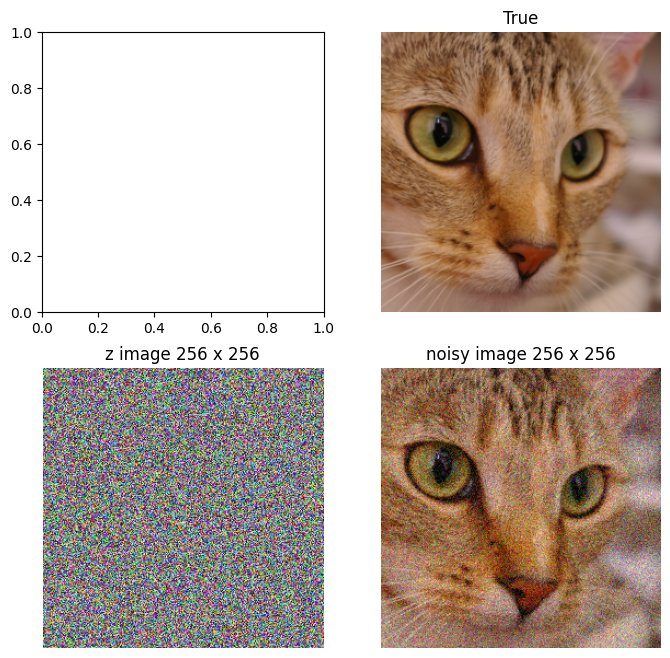

In [14]:
true_object_torch = np_to_torch(true_object_np).to(device)
noisy_object_torch = np_to_torch(noisy_object_np).to(device)

fig1, axs1 = plt.subplots(2,2, figsize=(8,8))

axs1[0,1].imshow(torch_to_np(true_object_torch),); axs1[0,1].set_title('True'); axs1[0,1].set_axis_off();
axs1[1,0].imshow(torch_to_np(input_image)); axs1[1,0].set_title(f'z image {nxd} x {nxd}'); axs1[1,0].set_axis_off();
axs1[1,1].imshow(torch_to_np(noisy_object_torch)); axs1[1,1].set_title(f'noisy image {nxd} x {nxd}'); axs1[1,1].set_axis_off();

In [15]:
import torch.nn.functional as F
def nrmse_fn(recon, reference):
  n = (reference-recon)**2; den = reference**2
  return 100*torch.mean(n)**0.5 / torch.mean(den)**0.5
  # return F.mse_loss(recon, reference)

In [16]:
def store_image(img, ep):
  img = (img * 255).cpu().detach().numpy().astype(np.uint8)
  image = Image.fromarray(np.transpose(img,(1,2,0)))
  image.save(f'output_epoch{ep}.png')

In [17]:
import time
from IPython.display import display, clear_output
from PIL import Image

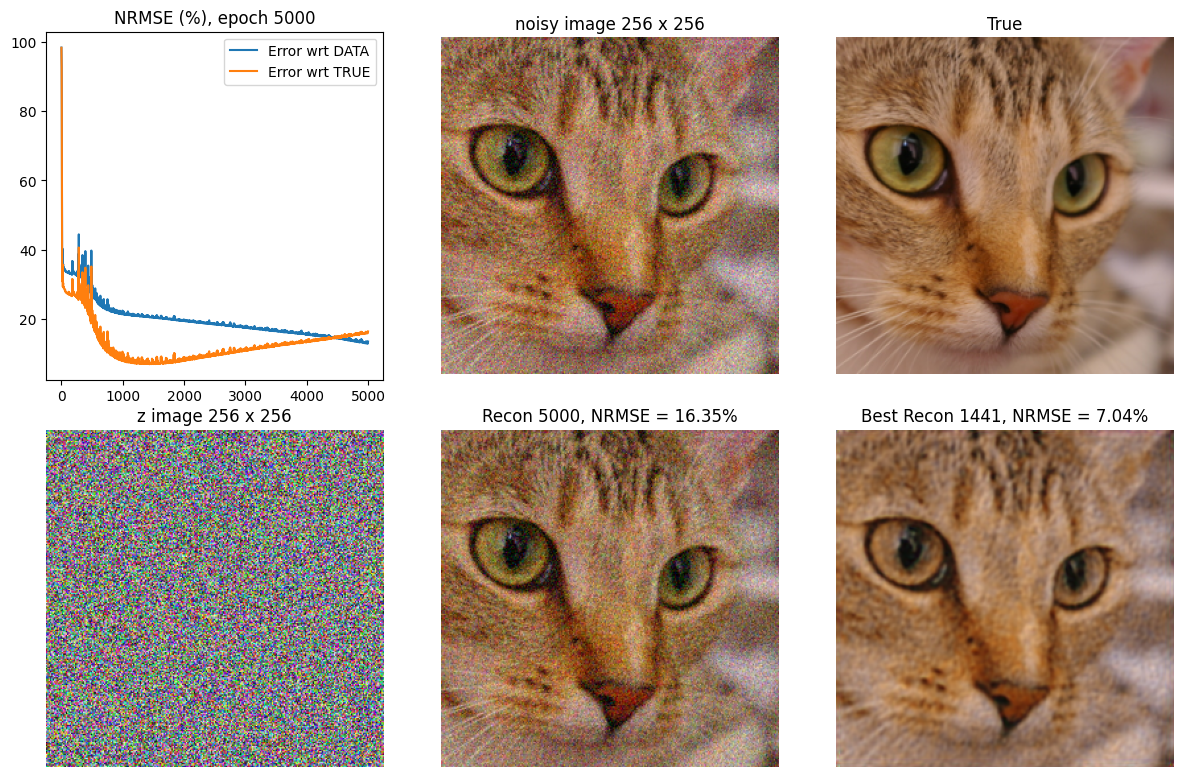

In [40]:
epoch = 5000

cnn = CNN(6, nxd, 3).to(device)
optimiser = torch.optim.Adam(cnn.parameters(), lr=1e-4)
train_loss = list(); nrmse_lsit =list(); best_nrmse = 10e9

fig1, axs1 = plt.subplots(2,3, figsize=(12,8))
plt.tight_layout();
axs1[0,2].imshow(torch_to_np(true_object_torch), cmap='Greys_r'); axs1[0,2].set_title('True'); axs1[0,2].set_axis_off();
axs1[0,1].imshow(torch_to_np(noisy_object_torch)); axs1[0,1].set_title(f'noisy image {nxd} x {nxd}'); axs1[0,1].set_axis_off();
axs1[1,0].imshow(torch_to_np(input_image), cmap='Greys_r'); axs1[1,0].set_title(f'z image {nxd} x {nxd}'); axs1[1,0].set_axis_off();
in_image = input_image.permute(2, 0, 1)

for ep in range(epoch+1):
  optimiser.zero_grad()
  output_image = cnn(in_image)

  loss = nrmse_fn(output_image, noisy_object_torch.permute(2, 0, 1))

  train_loss.append(loss.item())
  loss.backward()
  optimiser.step()

  nrmse = nrmse_fn(output_image, true_object_torch.permute(2, 0, 1))
  nrmse_lsit.append(nrmse.item())

  if nrmse < best_nrmse or ep == 0:
    if best_nrmse - nrmse < 0.0001 and nrmse < 10:
      store_image(output_image, ep)
      print(f"small enough in epoch{ep}")
      break
    best_recon = output_image; best_nrmse = nrmse; best_ep = ep
    axs1[1,2].cla(); axs1[1,2].imshow(torch_to_np(best_recon.permute(1,2,0)))
    axs1[1,2].set_title('Best Recon %d, NRMSE = %.2f%%' % (best_ep, best_nrmse))
    axs1[1,2].set_axis_off()

  if ep % 10 == 0:
    axs1[1,1].cla(); axs1[1,1].imshow(torch_to_np(output_image.permute(1,2,0)))
    axs1[1,1].set_title('Recon %d, NRMSE = %.2f%%' % (ep, nrmse))
    axs1[1,1].set_axis_off()
    axs1[0,0].cla(); axs1[0,0].plot(train_loss[:-1]); axs1[0,0].plot(nrmse_lsit[:-1])
    axs1[0,0].set_title('NRMSE (%%), epoch %d' % ep)
    axs1[0,0].legend(['Error wrt DATA','Error wrt TRUE'])
    store_image(output_image, ep)
    pass

  if ep % 100 == 0:
    display(plt.gcf())
    clear_output(wait=True)
    time.sleep(0.001)


In [19]:
!pip install diffusers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.6 MB/s eta 0:00:00


In [37]:
# Copyright 2024 The HuggingFace Team. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


from typing import List, Optional, Tuple, Union
from diffusers.pipelines.pipeline_utils import DiffusionPipeline, ImagePipelineOutput
from diffusers.utils.torch_utils import randn_tensor

class DDPMPipeline(DiffusionPipeline):

    model_cpu_offload_seq = "unet"

    def __init__(self, unet, scheduler):
      super().__init__()
      self.register_modules(unet=unet, scheduler=scheduler)

    @torch.no_grad()
    def __call__(
      self,
      input_image = None,
      start_step: int = 1000,
      end_step: int = -1,
      batch_size: int = 1,
      generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
      num_inference_steps: int = 1000,
      output_type: Optional[str] = "pil",
      return_dict: bool = True,
    ):

    # Sample gaussian noise to begin loop
      if isinstance(self.unet.config.sample_size, int):
        image_shape = (
          batch_size,
          self.unet.config.in_channels,
          self.unet.config.sample_size,
          self.unet.config.sample_size,
        )
      else:
        image_shape = (batch_size, self.unet.config.in_channels, *self.unet.config.sample_size)

      # modify here to get input image from the output of DIP
      if input_image is None:
        if self.device.type == "mps":
          # randn does not work reproducibly on mps
          image = randn_tensor(image_shape, generator=generator)
          image = image.to(self.device)
        else:
          image = randn_tensor(image_shape, generator=generator, device=self.device)
      else:
          image = input_image.to(self.device)
          image_to_output = image
          image_to_output = (image_to_output / 2 + 0.5).clamp(0, 1)
          image_to_output = image_to_output.cpu().permute(0, 2, 3, 1).numpy()
          yield ImagePipelineOutput(images=self.numpy_to_pil(image_to_output))
      # print(image.shape)
      # set step values
      self.scheduler.set_timesteps(num_inference_steps)

      # for t in self.progress_bar(self.scheduler.timesteps):
      for t in range(start_step,end_step,-1):
          # 1. predict noise model_output
          model_output = self.unet(image, t).sample
          # 2. compute previous image: x_t -> x_t-1
          image = self.scheduler.step(model_output, t, image, generator=generator).prev_sample
          if(t % 10 == 0):
            image_to_output = image
            image_to_output = (image_to_output / 2 + 0.5).clamp(0, 1)
            image_to_output = image_to_output.cpu().permute(0, 2, 3, 1).numpy()
            yield ImagePipelineOutput(images=self.numpy_to_pil(image_to_output))

      image = (image / 2 + 0.5).clamp(0, 1)
      image = image.cpu().permute(0, 2, 3, 1).numpy()

      if output_type == "pil":
        image = self.numpy_to_pil(image)

      if not return_dict:
        yield (image,)

      yield ImagePipelineOutput(images=image)


In [38]:
model_id = "google/ddpm-celebahq-256"

# load model and scheduler
ddpm = DDPMPipeline.from_pretrained(model_id).to(device)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


In [47]:
img = cv2.imread("output_epoch2500.png")
img = np_to_torch(img).permute(2, 0, 1)
img = img.unsqueeze(0) / 127.5 - 1
img = img[:,[2,1,0],:,:]
images = ddpm(input_image = img, start_step = 50)
# images = ddpm()
# save image
for i, image in enumerate(images):
  image.images[0].save(f"ddpm_generated_image_{i*10}.png")

In [46]:
import glob
import os
removing_files = glob.glob('./ddpm_generated_image_*.png')
for i in removing_files:
  os.remove(i)

In [116]:
removing_files = glob.glob('./output_epoch*.png')
for i in removing_files:
  os.remove(i)